# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries and set rcParams

In [19]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import cv2 as cv
from numpy.random import choice
import os
from ..src.data.filepaths import *

rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 5)
rcParams['image.cmap'] = 'gray'

ValueError: attempted relative import beyond top-level package

# For the first time make fingeprint image read function

In [20]:
# Images types 
TYPES = ['.jpg', '.jpeg', '.jpe',
         '.png', 
         '.bmp', '.dib',
         '.pbm', '.pgm', '.ppm',
         '.sr', '.ras',
         '.tiff', '.tif']

# Function for checking image type
def check_im_type(name: str):
    """
    check_im_type(name: str) -> bool
    """
    fl = False
    for tp in TYPES:
        if name.endswith(tp):
            fl = True
            break
    return fl

# function for getting 
def images_dir_list(listdir):
    return [name for name in listdir if check_im_type(name)]

# Read random function for images
def read_random_image(file_path, with_path=False, flag=cv.IMREAD_GRAYSCALE):
    '''
    read_random_image(file_path, [with_path=False, [flag=cv.IMREAD_GRAYSCALE)
    file_path - file, where images are stored
    with_path - if True return image's filepath and image
    flag - constant values from cv.imread(). Default cv.IMREAD_GREAYSCALE
    '''
    
    images_list = images_dir_list(os.listdir(file_path))
    image_name = choice(images_list)
    image_path = file_path + image_name
    
    if with_path:
        return image_path, cv.imread(image_path, flag)
    else:
        return cv.imread(image_path, flag)

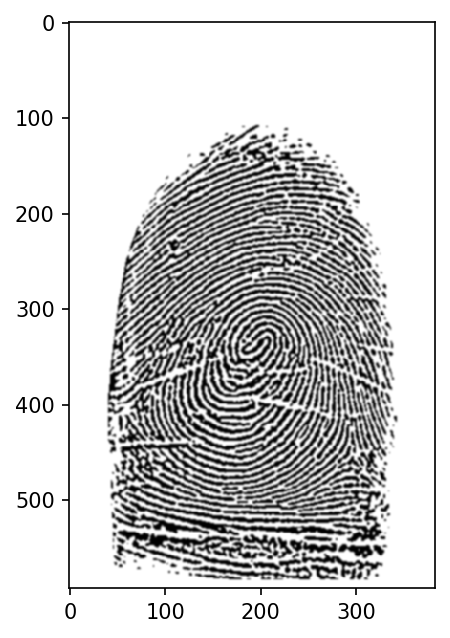

In [25]:
im = read_random_image(RAW_FILE_PATH_GOODIM)
plt.imshow(im)
plt.show()